# Variational Quantum Eigen Solver on 3 Qubit Circuit
Find the ground state energy eigen value of the given hamiltonian 
$$ Hamiltonian = \begin{bmatrix} 0.3 & 0 & 0 & 0 & 0 & 1.1 & 0 & 0 \\ 0 & -0.3 & 0 & 0 & 1.1 & 0 & 0 & 0\\ 0 & 0 & -0.3 & 0 & 0 & 0 & 0 & 0.7 \\ 0 & 0 & 0 & 0.3 & 0 & 0 & 0.7 & 0 \\ 0 & 1.1 & 0 & 0 & -0.3 & 0 & 0 & 0 \\ 1.1 & 0 & 0 & 0 & 0 & 0.3 & 0 & 0 \\ 0 & 0 & 0 & 0.7 & 0 & 0 & 0.3 & 0 \\ 0 & 0 & 0.7 & 0 & 0 & 0 & 0 & -0.3 \end{bmatrix}$$

Above Hamiltonian can be decomposed to fermionic basis
 $$Hamiltonian =  0.2(X \otimes Z \otimes X) + 0.9(X \otimes I \otimes X) + 0.3(Z \otimes Z \otimes Z) $$

Where $X,Z$ are pauli's spin matrices and $I$ is the Identity matrix


### Exact solution with Scipy

In [9]:
X = np.array([[0,1],[1,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[0,1]])



A = np.kron(X,np.kron(Z,X))
B = np.kron(X,np.kron(I,X))
C = np.kron(Z,np.kron(Z,Z))
H = (0.2*A) + (0.9*B) + (0.3*C)

#print(H)
eig_val,eig_vec = np.linalg.eig(H)
print('Lowest eigen value is:',round(eig_val.min(),2))

Lowest eigen value is: -1.4


In [10]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer as Aer
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from scipy.optimize import minimize
from scipy import array
from random import random
import matplotlib.pyplot as plt
from qiskit import *
#plt.style.use('dark_background')
#style = {'backgroundcolor': '#282c34'}

A choice of ANSATZ of specific choice with 3 variational parameters is given here with depth of 3

In [11]:
def parametric_state(theta): #------------- Creates ANSATZ
    """
    Creates ANSATZ with an 
    angle taking as parameter &
    returns a quantum circuit.
    :param theta: angle in radian
    :return: quantum circuit
    """
    q = QuantumRegister(3)
    c = ClassicalRegister(3)
    circuit = QuantumCircuit(q,c)
    for i in range(3):  #----------------circuit depth
        circuit.ccx(q[0],q[1],q[2] )
        circuit.ry(theta[0],q[0])
        circuit.ry(theta[1],q[1])
        circuit.ry(theta[2],q[2])
    return circuit

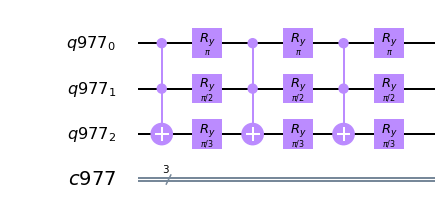

In [13]:
theta = [np.pi,np.pi/2,np.pi/3]
parametric_state(theta).draw(output='mpl')

In [4]:
## All the necessary functions for the algorithm is written here ##

def XZX(theta):
    """
    Gives expectation value of XZX
    sub-hamiltonian from measurement
    on parametric state.
    :param theta: angle in radian
    :return: expectation value of XZX
    """
    circuit = parametric_state(theta)
    ###########  Transformation on XZX ###########
    q = circuit.qregs[0]
    c = circuit.cregs[0]
    circuit.ry(-np.pi/2, q[0])
    circuit.ry(-np.pi/2, q[2])
    circuit.measure(q,c)
    ############  XZX measurement  ##############
    exp_XZX = measurement(circuit)
    return exp_XZX
    
def XIX(theta):
    """
    Gives expectation value of XIX
    sub-hamiltonian from measurement
    on parametric state.
    :param theta: angle in radian
    :return: expectation value of XIX
    """
    circuit = parametric_state(theta)
    ########### Transformation on YY #########
    q = circuit.qregs[0]
    c = circuit.cregs[0]
    circuit.ry(-np.pi/2, q[0])
    circuit.ry(-np.pi/2, q[2])
    circuit.measure(q,c)
    ############ YY Measurement ###########  
    exp_XIX = measurement(circuit)
    return exp_XIX

def ZZZ(theta):
    """
    Gives expectation value of ZZZ
    sub-hamiltonian from measurement
    on parametric state.
    :param theta: angle in radian
    :return: expectation value of ZZZ
    """
    circuit = parametric_state(theta)
    ##########################################
    q = circuit.qregs[0]
    c = circuit.cregs[0]
    circuit.measure(q,c)
    ###########  ZZ measurement ###############  
    exp_ZZZ = measurement(circuit)
    return exp_ZZZ

def vqe(theta):    #------------------- creates ansatz measures and performs addition to get the eigen value
    """
    Contain the complete Hamiltonian
    :param theta: angle is radian
    :return: expectation value of whole hamiltonian
    """                                                           # H = aXX + bYY + cZZ + dII
    E = (0.2*XZX(theta)) + (0.9*XIX(theta)) + (0.3*ZZZ(theta))  #Hamiltonian  with a,b,c,d
    return E

def key_check(my_dict: dict, my_key: str):
    """
    If key is missing returns 0
    otherwise the corresponding value.
    :param my_dict: the dictionary
    :param my_key: key (string)
    :return: 0 or value corresponding to key
    """
    response = 0
    if my_key in my_dict:
        response = my_dict[my_key]
    return response

    
def measurement(circuit):  # ------------------ Takes a quantum circuit and perform measurement
    """
    Takes the quantum circuit as
    input to perform measurement
    :param circuit: quantumm circuit
    :return: expectation value
    """
    shots =1024
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    n100 = key_check(counts,'100')
    n111 = key_check(counts,'111')
    n001 = key_check(counts,'001')
    n010 = key_check(counts,'010')
    n000 = key_check(counts,'000')
    n101 = key_check(counts,'101')
    n110 = key_check(counts,'110')
    n011 = key_check(counts,'011')
    expectation_value = ((n000+n111)-(n100+n001+n010+n101+n110+n011))/shots 
    return expectation_value

In [7]:
###########  VQE by Scipy Optimizers  ##############
theta = [2*np.pi,2*np.pi,2*np.pi]
result = minimize(vqe, theta, method="Powell")
print('Ground state energy from VQE is {}'.format(result.fun))
print('Success Status:',result.success,',',result.message)

Ground state energy from VQE is -1.4000000000000001
Success Status: True , Optimization terminated successfully.
